In [17]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
#import seaborn as sns

In [42]:
#from google.colab import drive
#drive.mount('/content/drive')

current_directory = os.getcwd()
print(current_directory)
print('...')
print('It is working!')
os.chdir("/content/drive/My Drive/Balancing1/RLOffloading")
current_directory = os.getcwd()
print(current_directory)
print(current_directory)

/content/drive/My Drive/Balancing1/RLOffloading
...
It is working!
/content/drive/My Drive/Balancing1/RLOffloading
/content/drive/My Drive/Balancing1/RLOffloading


April23  FedRL	May23  Oct23  RLOffloading


# Functions

In [3]:
def get_dummies(df, col, other_cols = []):
  # gets dummies of column 'col' of df, assuming they are separated with comma and space
  # other_cols : list of columns. if not [] then it will aggregate all these column in a new one called 'Others' and delete all the old columns in other_cols


    df_new = df[col].str.get_dummies(sep=', ')

    df_new['Others'] = df_new[other_cols].sum(axis=1)
    df_new['Others'] = df_new['Others'].apply(lambda x: 1 if x>0 else 0)
    df_new.drop(other_cols, axis=1, inplace = True)

    return df_new



def multi_col2latex(df, col, col_names_replace, filename):
    # col_names_replace : dictionary with old and new column names

    df_ = df[col].str.get_dummies(sep=', ')

    # fix column names
    df_.rename(columns=col_names_replace, inplace = True)


    binary_df2latex(df_, filename)

def get_subset(df, cols, replace_vals):
    df_sub = df[cols]
    df_sub = df_sub.replace(replace_vals[0], replace_vals[1])
    df_sub = df_sub.dropna()
    return df_sub


def plot_stacked(df, label_order):
    # label order should be a list of all possible values in the desired order
    df_ = df.apply(lambda x: x.value_counts(normalize = True)).T
    df_ = df_[label_order]
    ax = df_.plot.barh(stacked = True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(frameon=False, bbox_to_anchor=(1.05, 1.05))
    return ax





In [4]:
class Plots:
    def __init__(self, ax, xlabel = None, ylabel = None):

        self.ax = ax
        self.xlabel = xlabel
        self.ylabel = ylabel

    def clean_up(self):
        """settings common to all plots
        """

        self.ax.spines['top'].set_visible(False)
        self.ax.spines['right'].set_visible(False)

        if self.ax.legend_ is not None:
            self.ax.legend_.set_frame_on(False)  # Remove legend frame

        if self.xlabel is not None:
            self.ax.set_xlabel(self.xlabel)

        if self.ylabel is not None:
            self.ax.set_ylabel(self.ylabel)

class PlotsDataframe(Plots):
    """Plots all in self.ax

    Args:
        Plots (_type_): _description_
    """
    def __init__(self, df, ax ,**kwargs):

        super().__init__(ax, **kwargs)

        self.df = df

    def plot_series_bar(self):
        #print(self.df)

        self.df.sort_values().plot.barh(ax = self.ax)
        self.clean_up()

    def plot_df_bar(self, stacked = False):

        self.df.plot.barh(stacked = stacked, ax = self.ax)
        self.clean_up()


class Figures:

    def __init__(self, nrows = 1, ncols = 1):

        fig, axes = plt.subplots(nrows, ncols)

        self.fig = fig
        self.axes = axes

    def save_fig(self, filename):

        plt.savefig(filename, bbox_inches='tight')

    def add_plot(self, row = 0, col = 0):
        """Adds plot to the axis with indices [row,col]

        Args:
            row (int, optional): _description_. Defaults to 0.
            col (int, optional): _description_. Defaults to 0.
        """
        raise NotImplementedError












In [5]:


def binary_df2latex(df,filename):
  # converts a df of zeros and ones to latex
  # zeros become empty, ones become checkmarks
    df_ = df.copy()
    cols = df_.sum().sort_values(ascending = False).index.to_list() # get columns by largest number of appearance

    # if there is OThers col we move it ot the end
    if 'Others' in cols:
        cols.append(cols.pop(cols.index('Others')))

    df_ret = df_[cols]
    df_ret = df_ret.sort_values(by = cols, ascending =False) # sort each column


    df_ret.replace({0:np.nan}, inplace = True)
    df_ret.replace({1:'\checkmark'}, inplace = True)
    with open(filename, "w") as fh:
        df_ret.to_latex(buf=fh,float_format="{:.2f}".format, na_rep = '', escape  =False)


class Database:
    def __init__(self, path, index_col = 'Name', cite_col = 'Citation'):
        """ Reads data

        Args:
            path (str): path for csv file

            index_col (str, optional): column name to be index
            cite_col (str, optional): column name with latex citations

        """
        self.data = pd.read_csv(path)
        self.cite_col = cite_col

        self.data.set_index(index_col, inplace = True)
        self.get_cite_name()

    def get_cite_name(self):
        """ Retrives latex citation

        Args:
            col (str, optional): column where bibtex citations are found. Defaults to 'Citation'.
        """
        self.data['latex_cite'] = '\cite{' + self.data[self.cite_col].str.split('{').str[1].str.split(',').str[0] + '}'

    def writes_citations(self, filename):
        """Writes all citations in database to filename (added at the end of the file). Does not look for duplicates.

        Args:
            filename (str): path of output file
        """
        with open(filename, 'a') as f:
            for elem in self.data[self.cite_col]:
                f.write(elem + "\n" + "\n")

    def process_multiselect(self, df_col, rename_vals = {}, other_cols = []):
        """ Makes dummy columns out of a multiselect column, replaces names of options and aggregates in others

        Args:
            df_col (pd.Series): pandas series that corresponds to multiselect (i.e. several string options separated by comma)
            rename_vals (dict, optional): dictionary to rename the values. Defaults to {}.
            other_cols (list, optional): list of column names to aggregate in 'Others'. It will count all columns as the same. Defaults to [].
        """
        df = df_col.dropna().str.get_dummies(sep=', ') # turns options into dummy columns

        if len(other_cols) > 0:
            df['Others'] = df[other_cols].sum(axis=1)
            df['Others'] = df['Others'].apply(lambda x: 1 if x>0 else 0)
            df.drop(other_cols, axis=1, inplace = True)

        df.rename(columns = rename_vals, inplace = True)

        return df

    def creates_latex_table(self, col, filename, rename_vals = {}, other_cols = [] ):

        df = self.data[[col,'latex_cite']]
        df.set_index('latex_cite', inplace = True)
        df = self.process_multiselect(df[col] , rename_vals, other_cols)

        df.index.name = None
        binary_df2latex(df,filename)


    def process_select_same_options(self, df_cols, rename_vals = {}, other_cols = []):

        df = df_cols.dropna().apply(lambda x: x.value_counts(normalize = True)).T
        df.rename(columns = rename_vals, inplace = True)
        return df

    def classification(self, cols, rules, name):

        df = pd.DataFrame(self.data[cols].groupby(cols).size(), columns= ['Counts'])

        column_name = name
        df[column_name] = 0

        for key, value in rules.items():
            df.loc[value,column_name] = key

        return df

    #  -------------- Plots -------------- #

    def plot_multi_select(self, col, ax, rename_vals = {}, other_cols = [] , xlabel = '', ylabel = ''):
        """Plots multiselect column as an horizontal bar plot with the fraction of times each option appears in the whole dataset

        Args:
            col (str): column name to plot
            rename_vals (dict, optional): dictionary to rename the values. Defaults to {}.
            other_cols (list, optional): list of column names to aggregate in 'Others'. It will count all columns as the same. Defaults to [].
        """
        df = self.process_multiselect(self.data[col] , rename_vals, other_cols)

        pp = PlotsDataframe(df.mean(), ax, xlabel = xlabel, ylabel = ylabel)

        pp.plot_series_bar()

        #ax = plot_series_bar(df.mean())

    def plot_single_select(self, col, ax, rename_vals = {}, other_cols = [], xlabel = '', ylabel = ''):

        df = self.process_select_same_options(pd.DataFrame(self.data[col]) , rename_vals, other_cols).T

        pp = PlotsDataframe(df[df.columns[0]], ax, xlabel = xlabel, ylabel = ylabel)
        pp.plot_series_bar()

    def plot_select_aggregated(self,cols, ax, rename_vals = {}, other_cols = [], xlabel = '', ylabel = ''):

        df = self.process_select_same_options(self.data[cols] , rename_vals, other_cols)
        pp = PlotsDataframe(df, ax, xlabel = xlabel, ylabel = ylabel)
        pp.plot_df_bar(stacked=True)


    def plot_select_combinations(self,cols, rules, name, ax, xlabel = '', ylabel = ''):

        df = self.classification(cols, rules, name).set_index(name)

        pp = PlotsDataframe(df[df.columns[0]], ax, xlabel = xlabel, ylabel = ylabel)
        pp.plot_series_bar()

# Get data

In [6]:
path = 'database.csv'
data = Database(path)
#data.writes_citations('../references.bib')
#data.data.head()

FileNotFoundError: ignored

# Objective Function

NameError: ignored

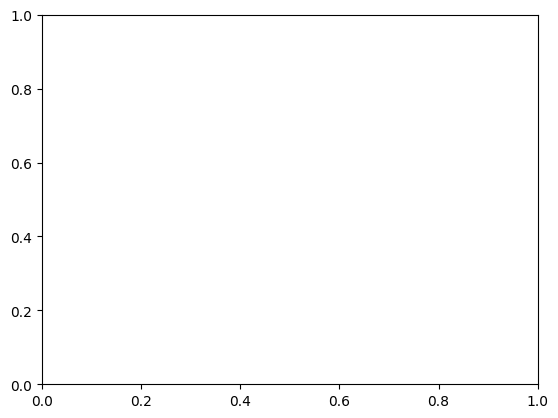

In [7]:
rename_vals ={'Price computation and transmission': 'Price'}
other_cols = ['Mining', 'Buffer length', 'Workload balance', 'Switching', 'Bandwidth', 'Overload']
fig = Figures()
data.plot_multi_select('Objective', fig.axes, rename_vals, other_cols, xlabel = 'Fraction')
fig.save_fig("../Figures/Objective.pdf")

data.creates_latex_table('Objective', '../Tables/obj_tab.tex', rename_vals, other_cols)

# Computation model

### Dropped tasks

NameError: ignored

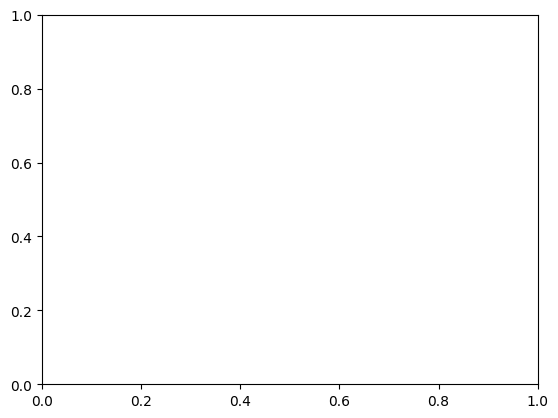

In [8]:
rename_vals ={}
other_cols = ['No coverage and no local resources', 'Max permitted latency', 'Max permitted energy']


fig = Figures()
data.plot_multi_select('Dropped tasks', fig.axes, rename_vals, other_cols, xlabel = 'Fraction')
fig.save_fig("../Figures/Dropped_tasks.pdf")

data.creates_latex_table('Dropped tasks', '../Tables/drop_tab.tex', rename_vals, other_cols)


# State Space

### Arrived tasks

NameError: ignored

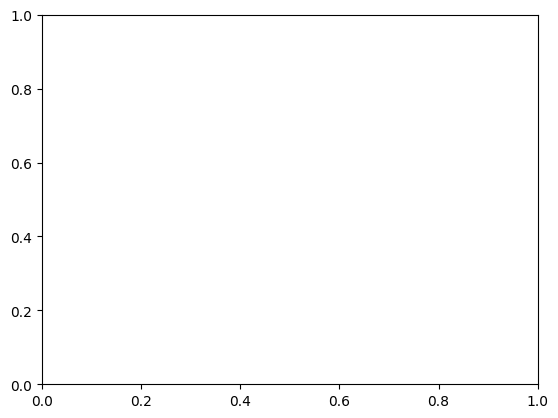

In [9]:
rename_vals ={'No': 'None', 'type': 'Type'}
other_cols = ['utility', 'priority', 'Bandwidth']
fig = Figures()
data.plot_multi_select('SS: Arrived tasks', fig.axes, rename_vals, other_cols)
fig.save_fig("../Figures/Arrived_tasks.pdf")

data.creates_latex_table('SS: Arrived tasks', '../Tables/ss_tasks.tex', rename_vals, other_cols)

### Nodes

NameError: ignored

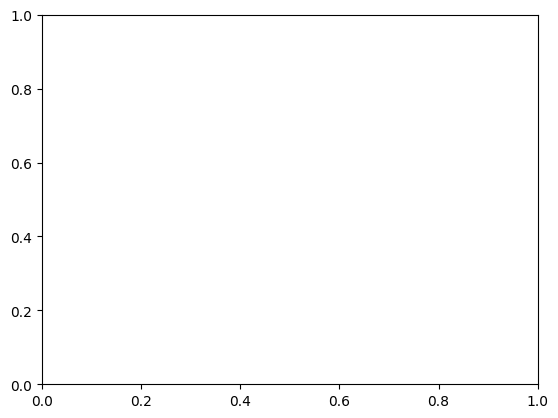

In [10]:
rename_vals ={}
other_cols = ['Current CPU usage', 'balance for mining', 'transmission delay']

fig = Figures()
data.plot_multi_select('SS: Node i', fig.axes, rename_vals, other_cols)
fig.save_fig("../Figures/NodeI.pdf")

# Offload model

### Offload where

NameError: ignored

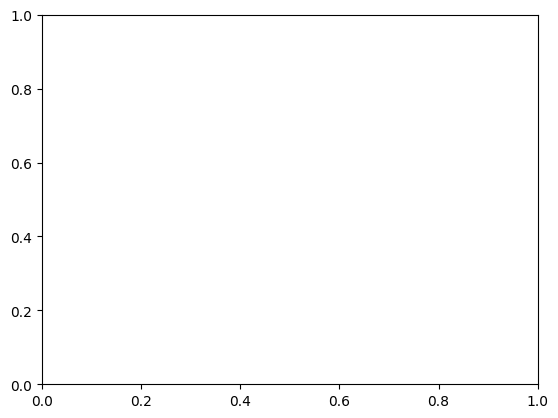

In [11]:
cols = ['Locally', 'Horizontal', 'Vertical']

fig = Figures()
data.plot_select_aggregated(cols,ax  =fig.axes)
fig.save_fig("../Figures/OffloadWhere_Agg.pdf")

In [ ]:
cols = ['Locally', 'Horizontal', 'Vertical']
name = 'Offload type'
rules = {'No local': ('No', 'No', 'Yes'),
                  'Horizontal': ('Yes', 'Yes', 'No'),
                  'Vertical': ('Yes', 'No', 'Yes'),
                  'Hybrid': ('Yes', 'Yes', 'Yes')}

fig = Figures()
data.plot_select_combinations(cols, rules, name, fig.axes, xlabel = 'Number')
fig.save_fig("../Figures/OffloadWhere_comb.pdf")

### Offload restrictions

NameError: ignored

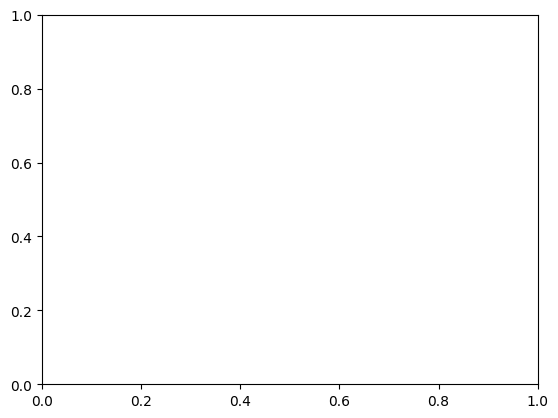

In [12]:
rename_vals ={'any': 'Anywhere', 'd < d_max': 'Distance', 'queue j not longer than queue i': 'Shorter queue', 'node idle': 'Node idle'}
other_cols = []

fig = Figures()
data.plot_multi_select('Offload where', fig.axes, rename_vals, other_cols, xlabel = 'Fraction')
fig.save_fig("../Figures/OffloadRestric.pdf")

data.creates_latex_table('Offload where', 'off_rest.tex', rename_vals, other_cols)

# Queue

NameError: ignored

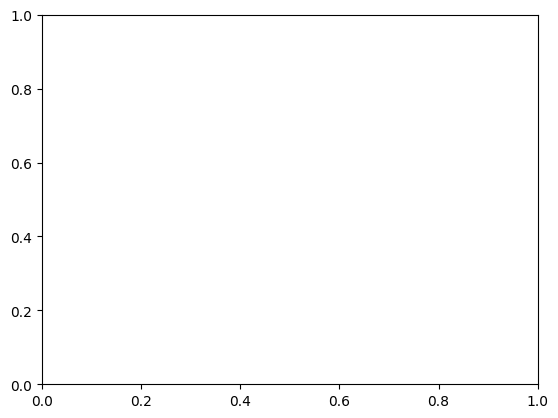

In [13]:
cols = ['Decision queue','Comm queue','Comp queue']
rename_vals ={'Maybe': 'No'}
other_cols = []

fig = Figures()
data.plot_select_aggregated(cols, fig.axes)
fig.save_fig("../Figures/Queue.pdf")

# Computation

NameError: ignored

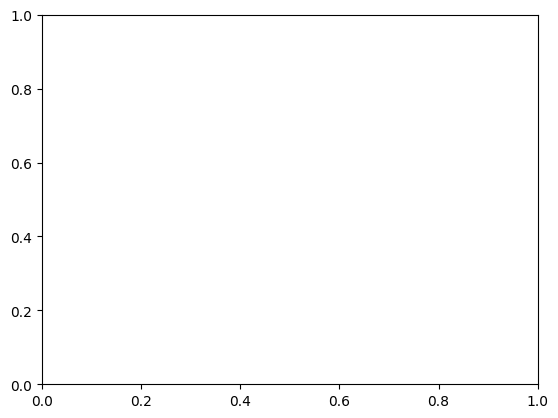

In [14]:
cols = ['Comp add costs','Comp latency','Comp energy']
rename_vals ={}
other_cols = []

fig = Figures()
data.plot_select_aggregated(cols, fig.axes, xlabel="Fraction")
fig.save_fig("../Figures/Comp.pdf")

### REstrictions

NameError: ignored

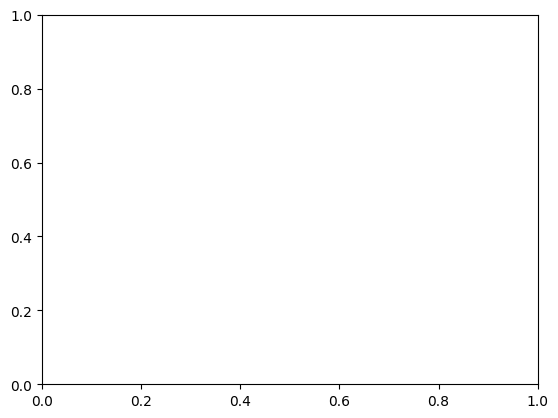

In [15]:
rename_vals ={}
other_cols = []

fig = Figures()
data.plot_multi_select('Comp restrictions', fig.axes,  rename_vals, other_cols, xlabel= 'Fraction')
fig.save_fig("../Figures/Comp_Restric.pdf")

# Properties

### Nodes

NameError: ignored

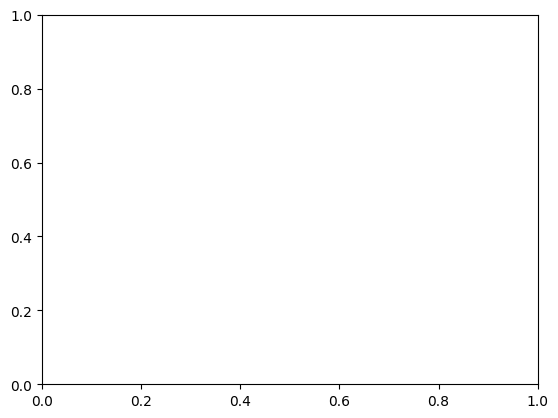

In [16]:
rename_vals = {}

fig = Figures()
data.plot_single_select('Mobility', fig.axes,rename_vals, xlabel= "Fraction")
fig.save_fig("../Figures/NodeProp.pdf")

In [ ]:
from sklearn.metrics import confusion_matrix

ModuleNotFoundError: No module named 'sklearn'

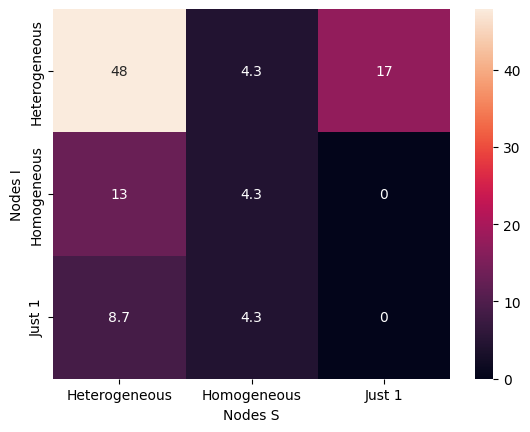

In [ ]:
data = confusion_matrix(df_prop_nodes['Nodes I'], df_prop_nodes['Nodes S'], labels = ['Heterogeneous', 'Homogeneous', 'Just 1'])
ax = sns.heatmap(100*data/df_prop_nodes.shape[0], xticklabels =  ['Heterogeneous', 'Homogeneous', 'Just 1'], yticklabels =  ['Heterogeneous', 'Homogeneous', 'Just 1'], annot = True)
ax.set_xlabel('Nodes S');
ax.set_ylabel('Nodes I');

### TAsks

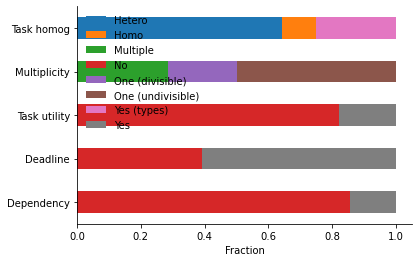

In [ ]:
cols = ['Dependency', 'Deadline', 'Task utility','Multiplicity','Task homog']
replace_vals = {'Types': 'Yes (types)'}


fig = Figures()
data.plot_select_aggregated(cols, fig.axes, replace_vals, xlabel="Fraction")
fig.save_fig("../Figures/TaskProp.pdf")

#data.creates_latex_table('SS: Arrived tasks', '../Tables/taskProp.tex', rename_vals, other_cols)